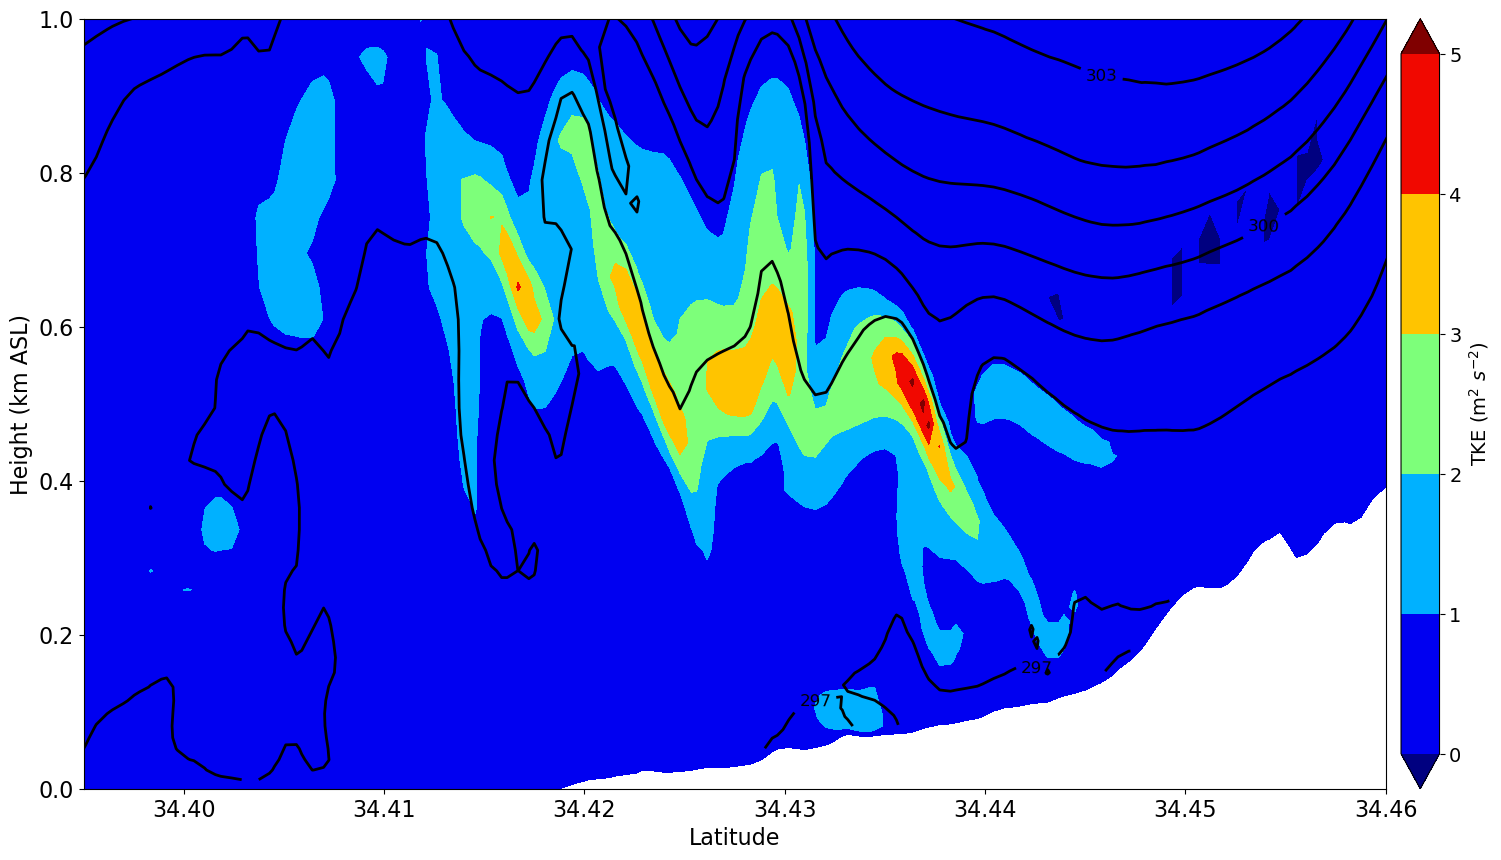

In [19]:
import glob
import os 
import matplotlib.pyplot as plt 
import matplotlib.dates as md
import numpy as np
import xarray as xr 
from datetime import datetime
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import wrf
from wrf import getvar, interplevel, interpline, CoordPair
import metpy
import metpy.calc 
from metpy.units import units
from metpy.plots import SkewT, Hodograph

wrf_file = ("/store01/pcrippa/ajanisz2/WRF-ERA5-SRTM-TKE-IOP1/wrfout_d05_2022-04-05_06:00:00")

read_in = xr.open_dataset(wrf_file)

mod_lon = read_in['XLONG'].values[0]
mod_lat = read_in['XLAT'].values[0]


w = read_in['W'][:].values
u = read_in['U'][:].values
v = read_in['V'][:].values
tke = read_in["TKE"].values

t = read_in['T'][:].values

lon = read_in['XLONG'][:].values[0]
lat = read_in['XLAT'][:].values[0]

g = 9.81 

ph = read_in.variables['PH'][:]  # Perturbation geopotential
phb = read_in.variables['PHB'][:]  # Base-state geopotential
hgt = read_in.variables['HGT'][:]  # Terrain height
pblh = read_in.variables['PBLH'][:]  # PBL Height

z = (ph + phb) / g  # Total geopotential height in meters

height_agl = (z - hgt).values


theta_p = read_in.variables['T'][:]  # Perturbation potential temperature
p = read_in.variables['P'][:]        # Perturbation pressure
pb = read_in.variables['PB'][:]      # Base-state pressure

p0 = 1000.0 * 100  # Reference pressure in Pa (hPa to Pa)
R = 287.0          # Specific gas constant for dry air
Cp = 1004.0        # Specific heat at constant pressure
kappa = R / Cp
P = p + pb

theta = theta_p + 300.0  # Assuming theta_0 = 300 K



start_lat, end_lat = 34.5, 34.35
start_lon, end_lon = -119.62, -119.62



def great_circle(latitude, longitude):

    radius = 6372795.
    
    if len(latitude) == 2 & len(longitude) == 2:
        latr1, lonr1 = np.radians(latitude[0]), np.radians(longitude[0])
        latr2, lonr2 = np.radians(latitude[1]), np.radians(longitude[1])
    else:
        latr1, lonr1 = np.radians(latitude[1:]), np.radians(longitude[1:])
        latr2, lonr2 = np.radians(latitude[:-1]), np.radians(longitude[:-1])

    sin_lat1, cos_lat1 = np.sin(latr1), np.cos(latr1)
    sin_lat2, cos_lat2 = np.sin(latr2), np.cos(latr2)

    delta_lon = lonr2 - lonr1
    cos_delta_lon, sin_delta_lon = np.cos(delta_lon), np.sin(delta_lon)

    d = np.arctan2(np.sqrt((cos_lat2 * sin_delta_lon) ** 2 +
                           (cos_lat1 * sin_lat2 -
                            sin_lat1 * cos_lat2 * cos_delta_lon) ** 2),
                   sin_lat1 * sin_lat2 + cos_lat1 * cos_lat2 * cos_delta_lon)

    return radius * d


dist = great_circle([start_lat, end_lat], [start_lon, end_lon])/1000
#num_points = np.round(dist/1.33, 0).astype(int)
num_points = 336

lat_match = np.linspace(start_lat, end_lat, num_points)
lon_match = np.linspace(start_lon, end_lon, num_points)


x_all = []
y_all = []

for i in range(len(lat_match)): 
    a = abs(mod_lat - lat_match[i]) + abs(mod_lon - lon_match[i])
    x,y = np.unravel_index(np.nanargmin(a), a.shape)

    x_all.append(x)
    y_all.append(y)

lon_2d = pd.concat([pd.DataFrame(lon[x_all, y_all])] * tke[0, :, x_all, y_all].shape[1], axis = 1).values
lat_2d = pd.concat([pd.DataFrame(lat[x_all, y_all])] * tke[0, :, x_all, y_all].shape[1], axis = 1).values




fig, ax= plt.subplots(figsize = (20, 10))
vmin = 0
vmax = 20
#cm = ax.pcolormesh(lat_2d, z.values[0, :76, x_all, y_all]/1000, v[0, :, x_all, y_all], cmap = "RdYlBu", vmin = -20, vmax = 0)
cm = ax.contourf(lat_2d, z.values[6, :76, x_all, y_all]/1000, v[6, :, x_all, y_all], extend = 'both', cmap = "RdYlBu",levels=np.linspace(vmin,vmax,11))
#cm = ax.pcolormesh(lat_2d, z.values[0, :90, x_all, y_all]/1000, tke[0, :91, x_all, y_all], cmap = 'bwr', vmin = 0, vmax = 5)
#cm = ax.contourf(lat_2d[:,:76], z.values[0, :76, x_all, y_all]/1000, tke[0, :76, x_all, y_all], cmap ='jet',  extend='both',levels=np.linspace(vmin,vmax,6))
#cm = ax.contourf(lat_2d, z.values[0, :90, x_all, y_all]/1000, v[0, :, x_all, y_all], cmap = 'bwr',  extend='both',levels=np.linspace(vmin,vmax,11))
#clab = ax.contour(lon_2d[:, 1:], z.values[0, 1:, x_all, y_all]/1000, T[0, :, x_all, y_all]-273.15, levels = np.arange(-60, 30, 2), colors = 'black')


cbar = plt.colorbar(cm, pad = 0.01)
cbar.set_label('TKE (m$^{2}$ $s^{-2}$)', fontsize = 14)
cbar.ax.tick_params(labelsize = 14)

ax.tick_params(labelsize = 16)
# ax2.tick_params(labelsize = 16)
# ax2.set_xlabel('Distance (km)', fontsize = 16)

ax.set_ylabel('Height (km ASL)', fontsize = 16) 
ax.set_xlabel('Latitude', fontsize = 16) 
ax.set_xlim(34.46, 34.395)

##d_theta_dz =  pd.DataFrame(theta_e.values[0, 1:, x_all, y_all]).diff(2, axis = 1) /  pd.DataFrame(z.values[0, 1:, x_all, y_all]).diff(2, axis = 1) * 1000
#cm = ax.pcolormesh(lon_2d[:, 1:], z.values[0, 1:, x_all, y_all]/1000, d_theta_dz, cmap = 'seismic', vmin = -10, vmax = 10)
clab = ax.contour(lat_2d[:, :108], z.values[0, 1:, x_all, y_all]/1000, theta.values[0, :, x_all, y_all], levels = np.arange(280, 360, 1), linewidths = 2, colors = 'black')
plt.clabel(clab, inline=1, fontsize=12, fmt="%i")
#
#ax.plot(lon[x_all, y_all], pblh.values[0, x_all, y_all]/1000, 'go--', linewidth=2)
ax.plot(lon[x_all, y_all], hgt.values[0, x_all, y_all]/1000, color = 'black', linewidth = 2)
plt.gca().invert_xaxis()
plt.ylim(0, 1)
plt.show()

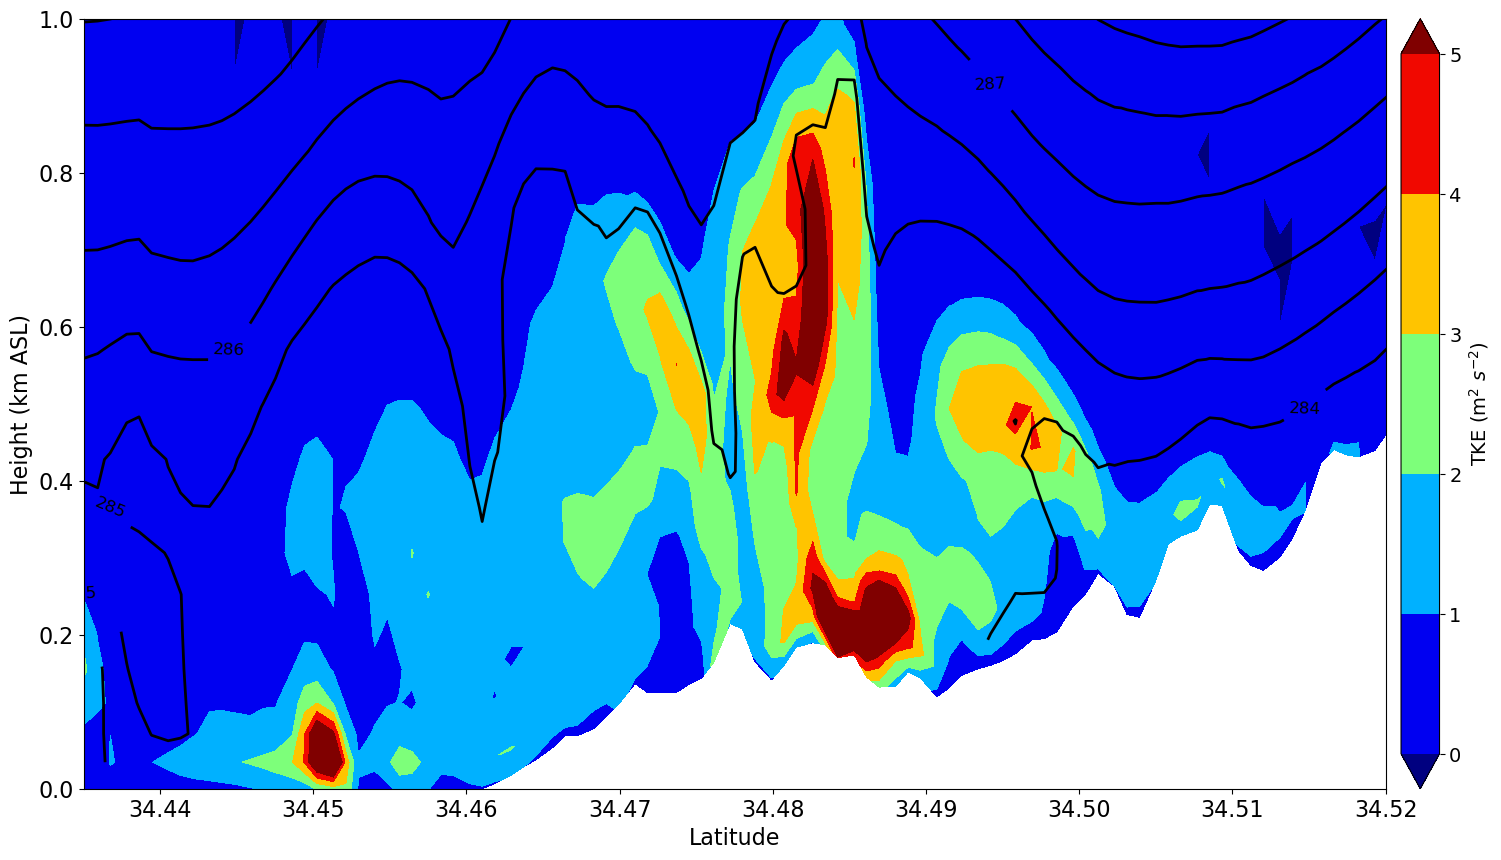

In [24]:
import glob
import os 
import matplotlib.pyplot as plt 
import matplotlib.dates as md
import numpy as np
import xarray as xr 
from datetime import datetime
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import wrf
from wrf import getvar, interplevel, interpline, CoordPair
import metpy
import metpy.calc 
from metpy.units import units
from metpy.plots import SkewT, Hodograph

wrf_file = ("/store01/pcrippa/ajanisz2/WRF-ERA5-SRTM-TKE-IOP8/wrfout_d05_2022-05-09_06:00:00")

read_in = xr.open_dataset(wrf_file)

mod_lon = read_in['XLONG'].values[0]
mod_lat = read_in['XLAT'].values[0]


w = read_in['W'][:].values
u = read_in['U'][:].values
v = read_in['V'][:].values
tke = read_in["TKE"].values

t = read_in['T'][:].values

lon = read_in['XLONG'][:].values[0]
lat = read_in['XLAT'][:].values[0]

g = 9.81 

ph = read_in.variables['PH'][:]  # Perturbation geopotential
phb = read_in.variables['PHB'][:]  # Base-state geopotential
hgt = read_in.variables['HGT'][:]  # Terrain height
pblh = read_in.variables['PBLH'][:]  # PBL Height

z = (ph + phb) / g  # Total geopotential height in meters

height_agl = (z - hgt).values


theta_p = read_in.variables['T'][:]  # Perturbation potential temperature
p = read_in.variables['P'][:]        # Perturbation pressure
pb = read_in.variables['PB'][:]      # Base-state pressure

p0 = 1000.0 * 100  # Reference pressure in Pa (hPa to Pa)
R = 287.0          # Specific gas constant for dry air
Cp = 1004.0        # Specific heat at constant pressure
kappa = R / Cp
P = p + pb

theta = theta_p + 300.0  # Assuming theta_0 = 300 K



start_lat, end_lat = 34.65, 34.35
start_lon, end_lon = -120.05, -120.05



def great_circle(latitude, longitude):

    radius = 6372795.
    
    if len(latitude) == 2 & len(longitude) == 2:
        latr1, lonr1 = np.radians(latitude[0]), np.radians(longitude[0])
        latr2, lonr2 = np.radians(latitude[1]), np.radians(longitude[1])
    else:
        latr1, lonr1 = np.radians(latitude[1:]), np.radians(longitude[1:])
        latr2, lonr2 = np.radians(latitude[:-1]), np.radians(longitude[:-1])

    sin_lat1, cos_lat1 = np.sin(latr1), np.cos(latr1)
    sin_lat2, cos_lat2 = np.sin(latr2), np.cos(latr2)

    delta_lon = lonr2 - lonr1
    cos_delta_lon, sin_delta_lon = np.cos(delta_lon), np.sin(delta_lon)

    d = np.arctan2(np.sqrt((cos_lat2 * sin_delta_lon) ** 2 +
                           (cos_lat1 * sin_lat2 -
                            sin_lat1 * cos_lat2 * cos_delta_lon) ** 2),
                   sin_lat1 * sin_lat2 + cos_lat1 * cos_lat2 * cos_delta_lon)

    return radius * d


dist = great_circle([start_lat, end_lat], [start_lon, end_lon])/1000
#num_points = np.round(dist/1.33, 0).astype(int)
num_points = 336

lat_match = np.linspace(start_lat, end_lat, num_points)
lon_match = np.linspace(start_lon, end_lon, num_points)


x_all = []
y_all = []

for i in range(len(lat_match)): 
    a = abs(mod_lat - lat_match[i]) + abs(mod_lon - lon_match[i])
    x,y = np.unravel_index(np.nanargmin(a), a.shape)

    x_all.append(x)
    y_all.append(y)

lon_2d = pd.concat([pd.DataFrame(lon[x_all, y_all])] * tke[0, :, x_all, y_all].shape[1], axis = 1).values
lat_2d = pd.concat([pd.DataFrame(lat[x_all, y_all])] * tke[0, :, x_all, y_all].shape[1], axis = 1).values




fig, ax= plt.subplots(figsize = (20, 10))
vmin = 0
vmax = 5
#cm = ax.pcolormesh(lat_2d, z.values[0, :76, x_all, y_all]/1000, v[0, :, x_all, y_all], cmap = "RdYlBu", vmin = -20, vmax = 0)
#cm = ax.contourf(lat_2d, z.values[6, :76, x_all, y_all]/1000, v[6, :, x_all, y_all], cmap = "RdYlBu",levels=np.linspace(vmin,vmax,11))
#cm = ax.pcolormesh(lat_2d, z.values[0, :90, x_all, y_all]/1000, tke[0, :91, x_all, y_all], cmap = 'bwr', vmin = 0, vmax = 5)
cm = ax.contourf(lat_2d[:,:76], z.values[0, :76, x_all, y_all]/1000, tke[0, :76, x_all, y_all], cmap = 'jet',  extend='both',levels=np.linspace(vmin,vmax,6))
#cm = ax.contourf(lat_2d, z.values[0, :90, x_all, y_all]/1000, v[0, :, x_all, y_all], cmap = 'bwr',  extend='both',levels=np.linspace(vmin,vmax,11))
#clab = ax.contour(lon_2d[:, 1:], z.values[0, 1:, x_all, y_all]/1000, T[0, :, x_all, y_all]-273.15, levels = np.arange(-60, 30, 2), colors = 'black')


cbar = plt.colorbar(cm, pad = 0.01)
cbar.set_label('TKE (m$^{2}$ $s^{-2}$)', fontsize = 14)
cbar.ax.tick_params(labelsize = 14)

ax.tick_params(labelsize = 16)
# ax2.tick_params(labelsize = 16)
# ax2.set_xlabel('Distance (km)', fontsize = 16)

ax.set_ylabel('Height (km ASL)', fontsize = 16) 
ax.set_xlabel('Latitude', fontsize = 16) 
ax.set_xlim(34.52, 34.435)

##d_theta_dz =  pd.DataFrame(theta_e.values[0, 1:, x_all, y_all]).diff(2, axis = 1) /  pd.DataFrame(z.values[0, 1:, x_all, y_all]).diff(2, axis = 1) * 1000
#cm = ax.pcolormesh(lon_2d[:, 1:], z.values[0, 1:, x_all, y_all]/1000, d_theta_dz, cmap = 'seismic', vmin = -10, vmax = 10)
clab = ax.contour(lat_2d[:, :76], z.values[0, 1:, x_all, y_all]/1000, theta.values[0, :, x_all, y_all], levels = np.arange(280, 360, 1), linewidths = 2, colors = 'black')
plt.clabel(clab, inline=1, fontsize=12, fmt="%i")
#
#ax.plot(lon[x_all, y_all], pblh.values[0, x_all, y_all]/1000, 'go--', linewidth=2)
ax.plot(lon[x_all, y_all], hgt.values[0, x_all, y_all]/1000, color = 'black', linewidth = 2)
plt.gca().invert_xaxis()
plt.ylim(0, 1)
plt.show()

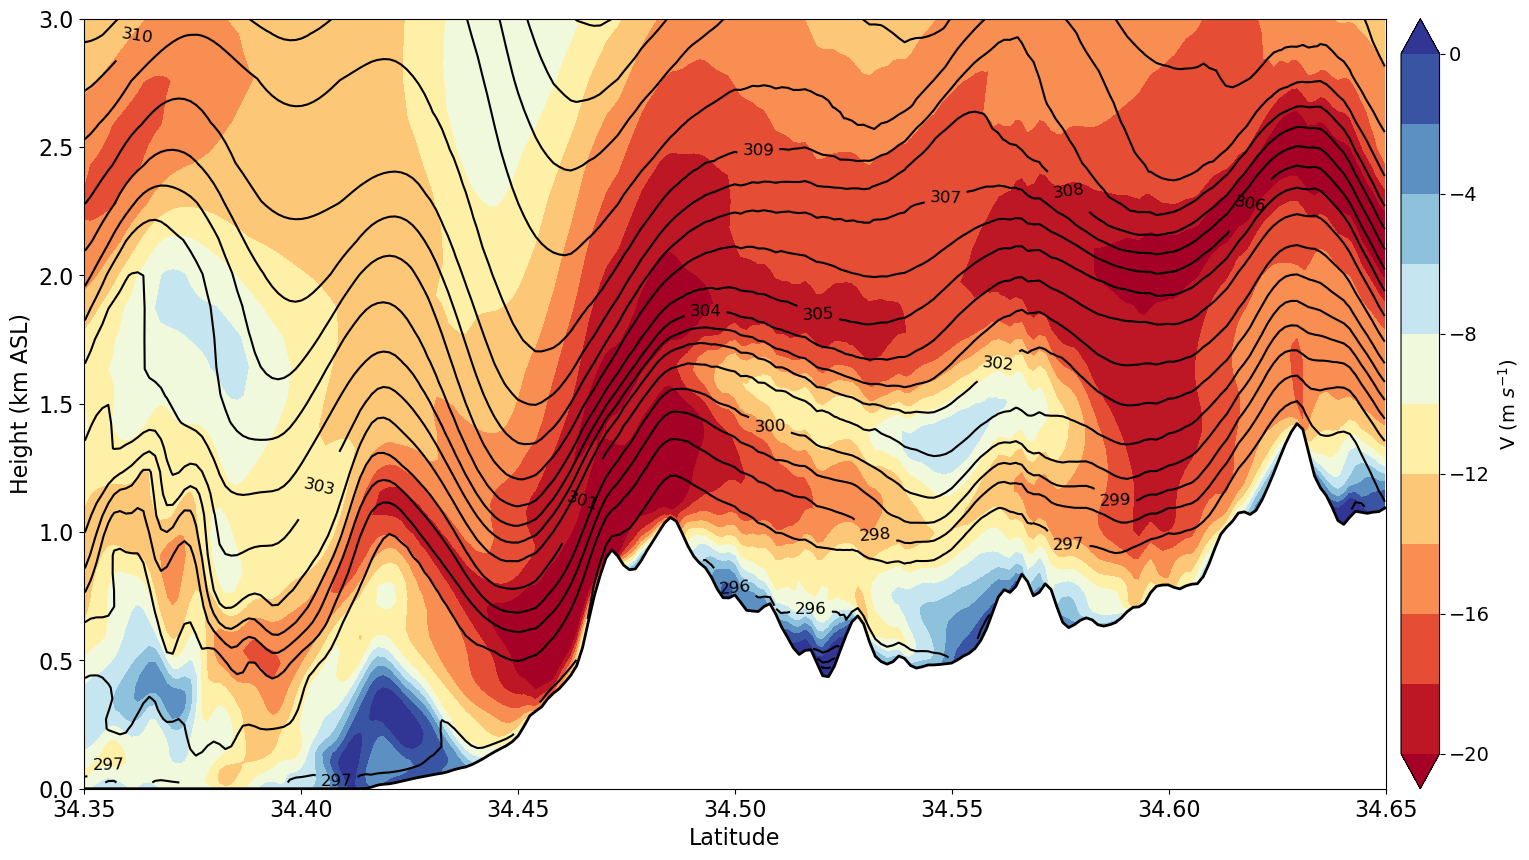

In [1]:
import glob
import os 
import matplotlib.pyplot as plt 
import matplotlib.dates as md
import numpy as np
import xarray as xr 
from datetime import datetime
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import wrf
from wrf import getvar, interplevel, interpline, CoordPair
import metpy
import metpy.calc 
from metpy.units import units
from metpy.plots import SkewT, Hodograph

wrf_file = ("/store01/pcrippa/ajanisz2/WRF-ERA5-SRTM-TKE-IOP1/wrfout_d04_2022-04-05_07:00:00")


read_in = xr.open_dataset(wrf_file)

mod_lon = read_in['XLONG'].values[0]
mod_lat = read_in['XLAT'].values[0]


w = read_in['W'][:].values
u = read_in['U'][:].values
v = read_in['V'][:].values
tke = read_in["TKE"].values

t = read_in['T'][:].values

lon = read_in['XLONG'][:].values[0]
lat = read_in['XLAT'][:].values[0]

g = 9.81 

ph = read_in.variables['PH'][:]  # Perturbation geopotential
phb = read_in.variables['PHB'][:]  # Base-state geopotential
hgt = read_in.variables['HGT'][:]  # Terrain height

z = (ph + phb) / g  # Total geopotential height in meters

height_agl = (z - hgt).values


theta_p = read_in.variables['T'][:]  # Perturbation potential temperature
p = read_in.variables['P'][:]        # Perturbation pressure
pb = read_in.variables['PB'][:]      # Base-state pressure

p0 = 1000.0 * 100  # Reference pressure in Pa (hPa to Pa)
R = 287.0          # Specific gas constant for dry air
Cp = 1004.0        # Specific heat at constant pressure
kappa = R / Cp
P = p + pb

theta = theta_p + 300.0  # Assuming theta_0 = 300 K



start_lat, end_lat = 34.65, 34.35
start_lon, end_lon = -119.64, -119.64



def great_circle(latitude, longitude):

    radius = 6372795.
    
    if len(latitude) == 2 & len(longitude) == 2:
        latr1, lonr1 = np.radians(latitude[0]), np.radians(longitude[0])
        latr2, lonr2 = np.radians(latitude[1]), np.radians(longitude[1])
    else:
        latr1, lonr1 = np.radians(latitude[1:]), np.radians(longitude[1:])
        latr2, lonr2 = np.radians(latitude[:-1]), np.radians(longitude[:-1])

    sin_lat1, cos_lat1 = np.sin(latr1), np.cos(latr1)
    sin_lat2, cos_lat2 = np.sin(latr2), np.cos(latr2)

    delta_lon = lonr2 - lonr1
    cos_delta_lon, sin_delta_lon = np.cos(delta_lon), np.sin(delta_lon)

    d = np.arctan2(np.sqrt((cos_lat2 * sin_delta_lon) ** 2 +
                           (cos_lat1 * sin_lat2 -
                            sin_lat1 * cos_lat2 * cos_delta_lon) ** 2),
                   sin_lat1 * sin_lat2 + cos_lat1 * cos_lat2 * cos_delta_lon)

    return radius * d


dist = great_circle([start_lat, end_lat], [start_lon, end_lon])/1000
#num_points = np.round(dist/1.33, 0).astype(int)
num_points = 336

lat_match = np.linspace(start_lat, end_lat, num_points)
lon_match = np.linspace(start_lon, end_lon, num_points)


x_all = []
y_all = []

for i in range(len(lat_match)): 
    a = abs(mod_lat - lat_match[i]) + abs(mod_lon - lon_match[i])
    x,y = np.unravel_index(np.nanargmin(a), a.shape)

    x_all.append(x)
    y_all.append(y)

lon_2d = pd.concat([pd.DataFrame(lon[x_all, y_all])] * v[0, :, x_all, y_all].shape[1], axis = 1).values
lat_2d = pd.concat([pd.DataFrame(lat[x_all, y_all])] * v[0, :, x_all, y_all].shape[1], axis = 1).values




fig, ax= plt.subplots(figsize = (20, 10))
vmin = -20
vmax = 0
#cm = ax.pcolormesh(lat_2d, z.values[0, :76, x_all, y_all]/1000, v[0, :, x_all, y_all], cmap = "RdYlBu", vmin = -20, vmax = 0)
cm = ax.contourf(lat_2d, z.values[0, :90, x_all, y_all]/1000, v[0, :, x_all, y_all], cmap = "RdYlBu", extend='both',levels=np.linspace(vmin,vmax,11))
#cm = ax.pcolormesh(lat_2d, z.values[0, :90, x_all, y_all]/1000, tke[0, :91, x_all, y_all], cmap = 'bwr', vmin = 0, vmax = 5)
#cm = ax.contourf(lat_2d, z.values[0, :90, x_all, y_all]/1000, tke[0, :91, x_all, y_all], cmap = 'bwr',  extend='both',levels=np.linspace(vmin,vmax,11))
#cm = ax.contourf(lat_2d, z.values[0, :90, x_all, y_all]/1000, v[0, :, x_all, y_all], cmap = 'bwr',  extend='both',levels=np.linspace(vmin,vmax,11))
#clab = ax.contour(lon_2d[:, 1:], z.values[0, 1:, x_all, y_all]/1000, T[0, :, x_all, y_all]-273.15, levels = np.arange(-60, 30, 2), colors = 'black')


ax.plot(lat[x_all, y_all], hgt.values[0, x_all, y_all]/1000, color = 'black', linewidth = 2)
cbar = plt.colorbar(cm, pad = 0.01)
cbar.set_label('V (m $s^{-1}$)', fontsize = 14)
cbar.ax.tick_params(labelsize = 14)

ax.tick_params(labelsize = 16)
ax.set_ylabel('Height (km ASL)', fontsize = 16) 
ax.set_xlabel('Latitude', fontsize = 16) 

ax.set_xlim(34.65, 34.35)


clab = ax.contour(lat_2d[:, :], z.values[0, 1:, x_all, y_all]/1000, theta.values[0, :, x_all, y_all], levels = np.arange(280, 360, 1), colors = 'black')
plt.clabel(clab, inline=1, fontsize=12, fmt="%i")
ax.plot(lon[x_all, y_all], hgt.values[0, x_all, y_all]/1000, color = 'black', linewidth = 2)
plt.gca().invert_xaxis()
plt.ylim(0, 3)
#
plt.show()